#Capstone Project - The Battle of the Neighborhoods

##Applied Data Science Capstone (IBM/Coursera)


###Table of contents

    Introduction: Problem Statement
    Dataset
    Methodology
    Analysis
    Results and Discussion
    Conclusion



##Introduction: Business Problem

The aim of this project is to select the safest borough in London based on the crime rate and to explore the neighborhoods of that borough to find the 10 most common venues in each neighborhood and finally cluster the neighborhoods using k-mean clustering.

This report will be of a great interest to the people who are looking to relocate to London. And in order to find a descent neighborhood or to hunt for an apartment, safety is considered as a major concern. The crime statistics will provide an insight into this issue and help us in solving the problem statement.

We will focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood suited to an individual's needs can be selected.


##Data
<hr>

According to the problem statement, major factors that will influence our decision are:

*   Total number of crimes commited in each of the borough during the last year.
*   The most common venues in each of the neighborhood in the safest borough selected.

Required Dataset Sources:


*   Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016: A dataset consisting of the crime statistics of each borough in London obtained from Kaggle
*   Scraping additional information of the different Boroughs in London from a Wikipedia page.: More information regarding the boroughs of London is scraped using the Beautifulsoup library
*   Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.: Co-ordinate of neighborhood will be obtained using Google Maps API geocoding   
    



##Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016

###London Crime Data

Data set URL: [https://www.kaggle.com/jboysen/london-crime]

Importing the required Libraries

In [3]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup # library for web scrapping  

#!pip install geocoder
import geocoder

#!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!pip install folium
import folium # plotting library

print('All Libraries imported.')

All Libraries imported.


Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = 'R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K' # your Foursquare ID
CLIENT_SECRET = '4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW' # your Foursquare Secret

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K
CLIENT_SECRET:4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW


Reading the dataset using Pandas

In [16]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/London Crime/london_crime_by_lsoa.csv')
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0.0,2016.0,11.0
1,E01001646,Greenwich,Violence Against the Person,Other violence,0.0,2016.0,11.0
2,E01000677,Bromley,Violence Against the Person,Other violence,0.0,2015.0,5.0
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0.0,2016.0,3.0
4,E01004563,Wandsworth,Robbery,Personal Property,0.0,2008.0,6.0


Accessing the most recent crime rates in dataset(2016)

In [17]:
# Taking only the most recent year (2016) and dropping the rest
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [18]:
# Shape of the data frame
df.shape

(20631, 7)

In [19]:
# View the top of the dataset 
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1.0,2016.0,8.0
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1.0,2016.0,4.0
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4.0,2016.0,8.0
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1.0,2016.0,8.0
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2.0,2016.0,11.0


Renaming the Columns

In [20]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1.0,2016.0,8.0
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1.0,2016.0,4.0
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4.0,2016.0,8.0
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1.0,2016.0,8.0
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2.0,2016.0,11.0


In [21]:
# View the information of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LSOA_Code       20631 non-null  object 
 1   Borough         20631 non-null  object 
 2   Major_Category  20631 non-null  object 
 3   Minor_Category  20631 non-null  object 
 4   No_of_Crimes    20631 non-null  float64
 5   Year            20631 non-null  float64
 6   Month           20631 non-null  float64
dtypes: float64(3), object(4)
memory usage: 1.1+ MB


Total number of crimes in each Borough

In [22]:
df['Borough'].value_counts()

Lambeth                   954
Southwark                 883
Croydon                   857
Newham                    828
Ealing                    811
Tower Hamlets             802
Brent                     786
Hackney                   781
Barnet                    753
Lewisham                  737
Haringey                  736
Enfield                   710
Wandsworth                700
Greenwich                 687
Camden                    682
Westminster               666
Hillingdon                666
Waltham Forest            655
Islington                 649
Hounslow                  631
Redbridge                 608
Bromley                   604
Hammersmith and Fulham    544
Barking and Dagenham      531
Havering                  522
Kensington and Chelsea    517
Harrow                    446
Merton                    441
Bexley                    429
Richmond upon Thames      377
Sutton                    347
Kingston upon Thames      284
City of London              7
Name: Boro

The total crimes per major category

In [23]:
df['Major_Category'].value_counts()

Theft and Handling             6618
Violence Against the Person    6578
Criminal Damage                2582
Burglary                       2307
Drugs                          1175
Robbery                         753
Other Notifiable Offences       618
Name: Major_Category, dtype: int64

Pivoting the table to view the no. of crimes for each major category in each Borough

In [24]:
London_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
London_crime.head()

No_of_Crimes  ...                            
Major_Category           Burglary  ... Violence Against the Person
Borough                            ...                            
Barking and Dagenham           92  ...                         335
Barnet                        191  ...                         364
Bexley                         51  ...                         231
Brent                         153  ...                         467
Bromley                       110  ...                         344

[5 rows x 7 columns]

In [25]:
# Reset the index
London_crime.reset_index(inplace = True)

In [26]:
# Total crimes per Borough
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head(30)

Borough  ... Total
Major_Category                          ...      
0                 Barking and Dagenham  ...   897
1                               Barnet  ...  1266
2                               Bexley  ...   690
3                                Brent  ...  1346
4                              Bromley  ...   958
5                               Camden  ...  1557
6                       City of London  ...     8
7                              Croydon  ...  1491
8                               Ealing  ...  1431
9                              Enfield  ...  1155
10                           Greenwich  ...  1207
11                             Hackney  ...  1492
12              Hammersmith and Fulham  ...  1145
13                            Haringey  ...  1457
14                              Harrow  ...   707
15                            Havering  ...   914
16                          Hillingdon  ...  1288
17                            Hounslow  ...  1108
18                           Islington  ...  1297
19              Kensington and Chelsea  ...  1049
20                Kingston upon Thames  ...   481
21                             Lambeth  ...  1937
22                            Lewisham  ...  1225
23                              Merton  ...   680
24                              Newham  ...  1761
25                           Redbridge  ...  1037
26                Richmond upon Thames  ...   555
27                           Southwark  ...  1704
28                              Sutton  ...   551
29                       Tower Hamlets  ...  1535

[30 rows x 9 columns]

Removing the multi index so that it will be easier to merge

In [27]:
London_crime.columns = London_crime.columns.map(''.join)
London_crime.head()

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,92,107,47,25,27,264,335,897
1,Barnet,191,115,41,29,26,500,364,1266
2,Bexley,51,99,42,11,7,249,231,690
3,Brent,153,112,87,30,40,457,467,1346
4,Bromley,110,104,35,24,17,324,344,958


Renaming the columns

In [28]:
London_crime.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
London_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,92,107,47,25,27,264,335,897
1,Barnet,191,115,41,29,26,500,364,1266
2,Bexley,51,99,42,11,7,249,231,690
3,Brent,153,112,87,30,40,457,467,1346
4,Bromley,110,104,35,24,17,324,344,958


In [29]:
# Shape of the data set 
London_crime.shape

(33, 9)

##Scraping additional information of the different Boroughs in London from a Wikipedia page

Using Beautiful soup to scrap the latitude and longitiude of the boroughs in London

URL: https://en.wikipedia.org/wiki/List_of_London_boroughs

In [36]:
# getting data from internet
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"eefd4dd5-d9bb-45bf-8f4f-8bd26c334eeb","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":958873870,"wgRevisionId":958873870,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of 

In [37]:
# extracting the raw table inside that webpage
table = soup.find_all('table', {'class':'wikitable sortable'})
print(table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a href="/wiki/Barking_Town_Hall" title="Barking Town Hall">Town Ha

Converting the table into a data frame

In [38]:
London_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


The second table on the site contains the addition Borough i.e. City of London

In [39]:
# Read in the second table 
London_table1 = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# Rename the columns to match the previous table to append the tables.

London_table1.columns = ['Borough','Inner','Status','Local authority','Political control',
                         'Headquarters','Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']

# View the table
London_table1

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


Append the data frame together

In [40]:
# A continuous index value will be maintained 
# across the rows in the new appended data frame. 

London_table = London_table.append(London_table1, ignore_index = True) 
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


Check if the last row was appended correctly

In [41]:
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


View the information of the data set

In [42]:
London_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Borough                   33 non-null     object 
 1   Inner                     4 non-null      object 
 2   Status                    5 non-null      object 
 3   Local authority           33 non-null     object 
 4   Political control         33 non-null     object 
 5   Headquarters              33 non-null     object 
 6   Area (sq mi)              33 non-null     float64
 7   Population (2013 est)[1]  33 non-null     int64  
 8   Co-ordinates              33 non-null     object 
 9   Nr. in map                33 non-null     int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.7+ KB


Removing Unnecessary string in the Data set

In [43]:
London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 

# View the top of the data set
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


Check the type of the newly created table

In [44]:
type(London_table)

pandas.core.frame.DataFrame

In [45]:
# Shape of the data frame
London_table.shape

(33, 10)

Check if the Borough in both the data frames match.

In [46]:
set(df.Borough) - set(London_table.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

These 3 Boroughs don't match because of the unnecessary symobols present "[]"

Find the index of the Boroughs that didn't match

In [48]:
print("The index of first borough is",London_table.index[London_table['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",London_table.index[London_table['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",London_table.index[London_table['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is [0]
The index of second borough is [9]
The index of third borough is [11]


Changing the Borough names to match the other data frame

In [49]:
London_table.iloc[0,0] = 'Barking and Dagenham'
London_table.iloc[9,0] = 'Greenwich'
London_table.iloc[11,0] = 'Hammersmith and Fulham'

Check if the Borough names in both data sets match

In [50]:
set(df.Borough) - set(London_table.Borough)

set()



The Borough names in both data frames match
We can combine both the data frames together

In [51]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head(10)

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham,92,107,47,25,27,264,335,897,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,191,115,41,29,26,500,364,1266,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,51,99,42,11,7,249,231,690,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,153,112,87,30,40,457,467,1346,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,110,104,35,24,17,324,344,958,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,133,119,106,21,51,683,444,1557,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,City of London,0,0,1,0,2,4,1,8,([],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1
7,Croydon,112,186,73,39,54,498,529,1491,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
8,Ealing,120,148,64,29,49,525,496,1431,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
9,Enfield,123,88,69,26,38,389,422,1155,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30


In [52]:
Ld_crime.shape

(33, 18)

In [53]:
set(df.Borough) - set(Ld_crime.Borough)

set()

Rearranging the Columns

In [54]:
# List of Column names of the data frame 
list(Ld_crime)

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2013 est)[1]',
 'Co-ordinates',
 'Nr. in map']

In [55]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,92,107,47,25,27,264,335,897
1,Barnet,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,191,115,41,29,26,500,364,1266
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,51,99,42,11,7,249,231,690
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,153,112,87,30,40,457,467,1346
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,110,104,35,24,17,324,344,958


##Methodology

The methodology in this project consists of two parts:


*   Exploratory Data Analysis: Visualise the crime rates in the London boroughs to idenity the safest borough and extract the neighborhoods in that borough to find the 10 most common venues in each neighborhood.
*   Modelling: To help people find similar neighborhoods in the safest borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 5 for this project that will cluster the 15 neighborhoods into 5 clusters. The reason to conduct a K- means clustering is to cluster neighborhoods with similar venues together so that people can shortlist the area of their interests based on the venues/amenities around each neighborhood. 



###Exploratory Data Analysis
Descriptive statistics of the data

In [56]:
London_crime.describe()

,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,110.121212,104.242424,65.212121,24.757576,33.333333,470.151515,373.727273,1181.545455
std,41.052373,35.411007,38.764318,11.797855,21.548879,251.751753,139.767278,485.989139
min,0.000000,0.000000,1.000000,0.000000,2.000000,4.000000,1.000000,8.000000
25%,82.000000,77.000000,41.000000,18.000000,14.000000,310.000000,309.000000,914.000000
50%,112.000000,107.000000,59.000000,25.000000,27.000000,457.000000,395.000000,1207.000000
75%,133.000000,124.000000,104.000000,30.000000,49.000000,566.000000,467.000000,1457.000000
max,191.000000,186.000000,169.000000,60.000000,73.000000,1446.000000,654.000000,2626.000000


Importing the Required Libraries

In [57]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Check if the column names are strings

In [58]:
Ld_crime.columns = list(map(str, Ld_crime.columns))

# let's check the column labels types now
all(isinstance(column, str) for column in Ld_crime.columns)

True

Sort the total crimes in descenting order to see 5 boroughs with the highest number of crimes

In [59]:
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Ld_crime.head() 
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
32,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,123,139,132,60,72,1446,654,2626
21,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,159,150,169,33,72,769,585,1937
24,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,116,124,107,28,73,832,481,1761
27,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,167,151,107,37,46,659,537,1704
5,Camden,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,133,119,106,21,51,683,444,1557


Visualize the five boroughs with the highest number of crimes

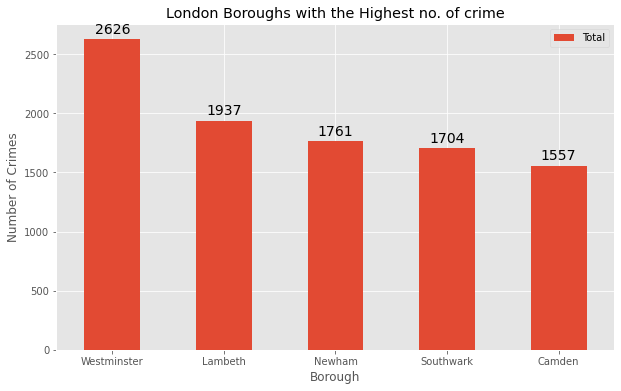

In [60]:
df_tt = df_top5[['Borough','Total']]

df_tt.set_index('Borough',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

Sort the total crimes in ascending order to see 5 boroughs with the highest number of crimes

In [62]:
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Ld_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,0,0,1,0,2,4,1,8
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,43,59,26,12,3,182,156,481
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,57,65,20,9,7,184,209,551
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,80,72,12,8,4,224,155,555
23,Merton,Merton London Borough Council,Labour,"Civic Centre, London Road",14.52,203223,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,81,77,16,20,11,270,205,680


Visualize the five boroughs with the least number of crimes

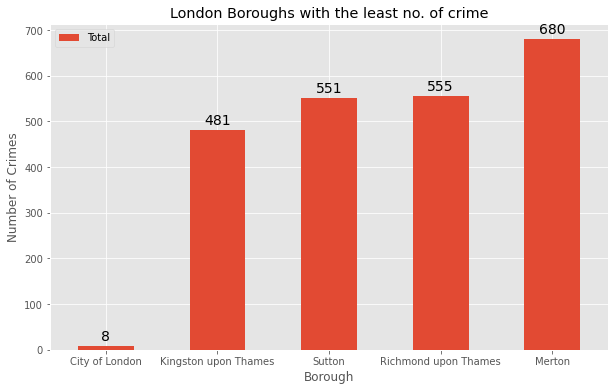

In [63]:
df_bt = df_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

The borough City of London has the lowest no. of crimes recorded for the year 2016, Looking into the details of the borough:

In [64]:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population (2013 est)[1]']]
df_col

,Borough,Total,Area (sq mi),Population (2013 est)[1]
6,City of London,8,1.12,7000


Visualizing different types of crimes in the borough 'Kingston upon Thames'

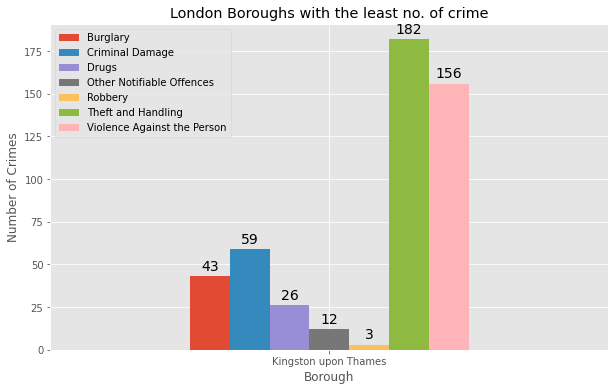

In [65]:
df_bc1 =  df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

**We can conclude that Kingston upon Thames is the safest borough when compared to the other boroughs in London.**

##Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates. 
<hr>

The list of Neighborhoods in the Royal Borough of Kingston upon Thames was found on a wikipedia page: https://en.wikipedia.org/wiki/List_of_districts_in_the_Royal_Borough_of_Kingston_upon_Thames

In [66]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


Find the Co-ordiantes of each Neighborhood in the Kingston upon Thames Neighborhood

In [67]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


In [68]:
df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


Get the co-ordinates of Berrylands, London, United Kingdom (The center neighborhood of Kingston upon Thames)

In [69]:
address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3937811, -0.2848024.


Visualize the Neighborhood of Kingston upon Thames Borough

In [70]:
# create map of New York using latitude and longitude values
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

##Modelling


*   Finding all the venues within a 500 meter radius of each neighborhood.
*   Perform one hot ecoding on the venues data.
*   Grouping the venues by the neighborhood and calculating their mean.
*   Performing a K-means clustering (Defining K = 5)




    
    
    
    



Create a function to extract the venues from each Neighborhood

In [71]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [72]:
kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )

Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [73]:
print(kut_venues.shape)
kut_venues.head()

(175, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
2,Berrylands,51.393781,-0.284802,Cafe Rosa,51.390175,-0.282490,Café
3,Berrylands,51.393781,-0.284802,Kamala Food and Wine,51.397810,-0.284045,Wine Shop
4,Canbury,51.417499,-0.305553,Canbury Gardens,51.417409,-0.305300,Park


In [74]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,4,4,4,4,4,4
Canbury,14,14,14,14,14,14
Chessington,1,1,1,1,1,1
Hook,5,5,5,5,5,5
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,4,4,4,4,4,4
New Malden,6,6,6,6,6,6


In [75]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 70 uniques categories.


One hot encoding

In [77]:
# one hot encoding
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Bus Stop,Café,Cajun / Creole Restaurant,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gastropub,German Restaurant,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hotel,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Market,Park,Pet Café,Pharmacy,Pizza Place,Platform,Plaza,Portuguese Restaurant,Pub,Record Shop,Rental Car Location,Restaurant,Sandwich Place,Seafood Restaurant,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Berrylands,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Canbury,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [78]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Bus Stop,Café,Cajun / Creole Restaurant,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gastropub,German Restaurant,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hotel,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Market,Park,Pet Café,Pharmacy,Pizza Place,Platform,Plaza,Portuguese Restaurant,Pub,Record Shop,Rental Car Location,Restaurant,Sandwich Place,Seafood Restaurant,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000
1,Canbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.00,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Chessington,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Hook,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kingston Vale,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000

In [79]:
kut_grouped.shape

(14, 71)

In [80]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                  venue  freq
0             Wine Shop  0.25
1  Gym / Fitness Center  0.25
2                  Café  0.25
3              Bus Stop  0.25
4                Market  0.00


----Canbury----
                  venue  freq
0                   Pub  0.29
1        Shop & Service  0.07
2                  Café  0.07
3  Gym / Fitness Center  0.07
4                 Plaza  0.07


----Chessington----
                 venue  freq
0                 Park   1.0
1     Asian Restaurant   0.0
2  Japanese Restaurant   0.0
3          Pizza Place   0.0
4             Pharmacy   0.0


----Hook----
               venue  freq
0                Pub   0.2
1             Bakery   0.2
2  Indian Restaurant   0.2
3        Supermarket   0.2
4  Fish & Chips Shop   0.2


----Kingston Vale----
              venue  freq
0      Soccer Field  0.25
1     Grocery Store  0.25
2               Bar  0.25
3    Sandwich Place  0.25
4  Asian Restaurant  0.00


----Kingston upon Thames----
              venue


Create a data frame of the venues

Function to sort the venues in descending order.


In [81]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood

In [83]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Wine Shop,Gym / Fitness Center,Café,Bus Stop,Farmers Market,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Fast Food Restaurant
1,Canbury,Pub,Café,Shop & Service,Plaza,Indian Restaurant,Hotel,Park,Gym / Fitness Center,Spa,Supermarket
2,Chessington,Park,Wine Shop,Farmers Market,Cosmetics Shop,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Fast Food Restaurant,Construction & Landscaping
3,Hook,Indian Restaurant,Pub,Bakery,Supermarket,Fish & Chips Shop,Wine Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dry Cleaner
4,Kingston Vale,Sandwich Place,Grocery Store,Bar,Soccer Field,Wine Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store


Clustering similar neighborhoods together using k - means clustering

In [84]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 1, 0, 1, 2, 1, 2, 2, 1, 1], dtype=int32)

In [85]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3.0,Wine Shop,Gym / Fitness Center,Café,Bus Stop,Farmers Market,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Fast Food Restaurant
1,Canbury,Kingston upon Thames,51.417499,-0.305553,1.0,Pub,Café,Shop & Service,Plaza,Indian Restaurant,Hotel,Park,Gym / Fitness Center,Spa,Supermarket
2,Chessington,Kingston upon Thames,51.358336,-0.298622,0.0,Park,Wine Shop,Farmers Market,Cosmetics Shop,Deli / Bodega,Department Store,Dry Cleaner,Electronics Store,Fast Food Restaurant,Construction & Landscaping
3,Coombe,Kingston upon Thames,51.419450,-0.265398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hook,Kingston upon Thames,51.367898,-0.307145,1.0,Indian Restaurant,Pub,Bakery,Supermarket,Fish & Chips Shop,Wine Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dry Cleaner


In [86]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            15 non-null     object 
 1   Borough                 15 non-null     object 
 2   Latitude                15 non-null     float64
 3   Longitude               15 non-null     float64
 4   Cluster Labels          14 non-null     float64
 5   1st Most Common Venue   14 non-null     object 
 6   2nd Most Common Venue   14 non-null     object 
 7   3rd Most Common Venue   14 non-null     object 
 8   4th Most Common Venue   14 non-null     object 
 9   5th Most Common Venue   14 non-null     object 
 10  6th Most Common Venue   14 non-null     object 
 11  7th Most Common Venue   14 non-null     object 
 12  8th Most Common Venue   14 non-null     object 
 13  9th Most Common Venue   14 non-null     object 
 14  10th Most Common Venue  14 non-null     obje

In [87]:
# Dropping the row with the NaN value 
kut_merged.dropna(inplace = True)

In [88]:
kut_merged.shape

(14, 15)

In [89]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [90]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            14 non-null     object 
 1   Borough                 14 non-null     object 
 2   Latitude                14 non-null     float64
 3   Longitude               14 non-null     float64
 4   Cluster Labels          14 non-null     int64  
 5   1st Most Common Venue   14 non-null     object 
 6   2nd Most Common Venue   14 non-null     object 
 7   3rd Most Common Venue   14 non-null     object 
 8   4th Most Common Venue   14 non-null     object 
 9   5th Most Common Venue   14 non-null     object 
 10  6th Most Common Venue   14 non-null     object 
 11  7th Most Common Venue   14 non-null     object 
 12  8th Most Common Venue   14 non-null     object 
 13  9th Most Common Venue   14 non-null     object 
 14  10th Most Common Venue  14 non-null     obje

Visualize the clusters

In [91]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

##Results and Discussion
<hr>
The project aims to help people who want to relocate to the safest borough in London, expats can chose the neighborhoods to which they want to relocate based on the most common venues in it. For example if a person is looking for a neighborhood with good connectivity and public transportation we can see that Clusters 3 and 4 have Train stations and Bus stops as the most common venues. If a person is looking for a neighborhood with stores and restaurants in a close proximity then the neighborhoods in the first cluster is suitable. For a family I feel that the neighborhoods in Cluster 4 are more suitable dues to the common venues in that cluster, these neighborhoods have common venues such as Parks, Gym/Fitness centers, Bus Stops, Restaurants, Electronics Stores and Soccer fields which is ideal for a family.


##Conclusion
<hr>
It is always helpful to make use of technology to stay one step ahead i.e. finding out more about places before moving into a neighborhood. We have just taken safety as a primary concern to shortlist the borough of London. The future of this project includes taking other factors such as cost of living in the areas into consideration to shortlist the borough based on safety and a predefined budget.
